# Problem statement
- Given review, we need to classify them as positive or negative.
- For this problem we are going to get sentence embedding(review embedding) using Pretrained BERT model and then using that review vector we are going to build Neural Network model for the binary classification task...

In [2]:
# mounted my Google Drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
!cp -r "/content/drive/MyDrive/NLP transfer learning/Copy of Reviews.csv" "/content"

In [9]:
!cp -r "/content/drive/MyDrive/NLP transfer learning/Copy of tokenization.py" "/content"

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [11]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Copy of Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [12]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews[['Text', 'Score']]
reviews.dropna(subset=['Text', 'Score'], inplace=True)

In [13]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

# Replace values in the Score column
# Replace values in the Score column
reviews['Score'] = np.where(reviews['Score'] > 3, 1, np.where(reviews['Score'] <= 2, 0, reviews['Score']))

# Drop rows where Score is 3
reviews = reviews[reviews['Score'] != 3]

In [15]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [16]:
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [17]:
#remove HTML from the Text column and save in the Text column only
import re
from bs4 import BeautifulSoup

def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

reviews['Text'] = reviews['Text'].apply(remove_html)


In [18]:
#print head 5
reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [19]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X = reviews['Text']  # X will be the Text column
y = reviews['Score']  # y will be the Score column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

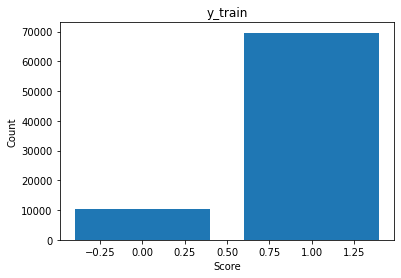

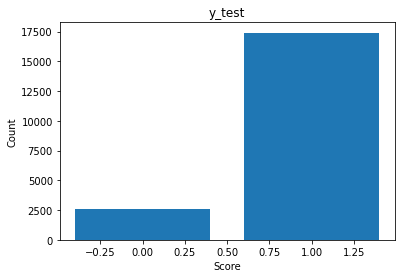

In [20]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt

# Create a bar plot of y_train
plt.bar(y_train.value_counts().index, y_train.value_counts())
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('y_train')
plt.show()

# Create a bar plot of y_test
plt.bar(y_test.value_counts().index, y_test.value_counts())
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('y_test')
plt.show()


In [21]:
print(y_train.value_counts().index)

Int64Index([1, 0], dtype='int64')


In [22]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

In [23]:
!cp -r "/content/preprocessed.csv"  "/content/drive/MyDrive/NLP transfer learning" 

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [24]:
reviews['len'] 

64117     30
418112    31
357829    41
175872    27
178716    22
          ..
336657    39
498034    28
357766    21
326811    23
19261     28
Name: len, Length: 100000, dtype: int64

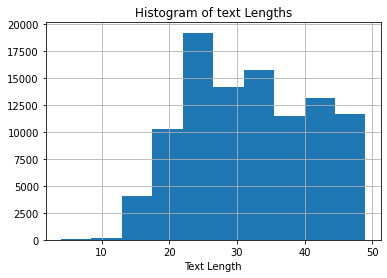

In [25]:


# Plot the histogram
reviews['len'].hist()

# Add a title and x-axis label
plt.title('Histogram of text Lengths')
plt.xlabel('Text Length')

# Show the plot
plt.show()


In [26]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output(output at the CLS place) not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [27]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [28]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [29]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [30]:
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import tokenization  #We have given tokenization.py file

In [32]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation


In [33]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time
#!pip install sentencepiece
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [35]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [37]:

# Create the input tokens for the train and test sets
X_train_tokens = []
X_train_mask=[]
X_train_segment=[]

X_test_tokens = []
X_test_mask=[]
X_test_segment=[]


for text in X_train:
  tokens = tokenizer.tokenize(text)
  if len(tokens)>max_seq_length-2:
    tokens=tokens[0:(max_seq_length-2)]
  tokens=['[CLS]',*tokens,'[SEP]']
  tokens = tokenizer.convert_tokens_to_ids(tokens)
  X_train_tokens.append(tokens)
  X_train_mask.append(np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens))))
  X_train_segment.append(np.array([0]*(max_seq_length)))
#X_train_tokens= X_train_tokens.numpy()



for text in X_test:
  tokens = tokenizer.tokenize(text)
  #print(len(text))
  if len(tokens)>max_seq_length-2:
    tokens=tokens[0:(max_seq_length-2)]
  tokens=['[CLS]',*tokens,'[SEP]']
  tokens = tokenizer.convert_tokens_to_ids(tokens)
  X_test_tokens.append(tokens)
  X_test_mask.append(np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens))))
  X_test_segment.append(np.array([0]*(max_seq_length)))
#X_test_tokens= X_test_tokens.numpy()


# Pad or truncate the input tokens so that they have a fixed length of max_seq_length
X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_seq_length, truncating='post', padding='post')
X_test_tokens = pad_sequences(X_test_tokens, maxlen=max_seq_length, truncating='post', padding='post')

In [38]:
X_train_tokens[0]

array([  101,  1045,  2018,  2196,  2699,  2023,  4435,  2077,  1010,
        2061,  1045,  2001,  5191,  2055,  1996,  3737,  1012,  2009,
       12595,  2307,  1012,  1037,  2200,  3835,  5744,  4138,  2440,
       14894,  1012,  2049,  2026,  2047,  5684,  3388,  1012,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [39]:
X_train_mask=np.asarray(X_train_mask)       #converting list to numpy array
X_train_segment = np.asarray(X_train_segment)
X_test_mask=np.asarray(X_test_mask)
X_test_segment=np.asarray(X_test_segment)



#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [40]:
import pickle

In [41]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [42]:
#!cp -r "/content/train_data.pkl" "/content/drive/MyDrive/NLP transfer learning" 
#!cp -r "/content/test_data.pkl" "/content/drive/MyDrive/NLP transfer learning" 

In [43]:
!cp -r "/content/drive/MyDrive/NLP transfer learning/train_data.pkl" "/content"
!cp -r "/content/drive/MyDrive/NLP transfer learning/test_data.pkl" "/content"

In [44]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

In [45]:
max_seq_length = 55

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [48]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [49]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [50]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

2500/2500 [==============================] - 307s 122ms/step


In [51]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

625/625 [==============================] - 78s 124ms/step


In [52]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [53]:
!cp -r "/content/final_output.pkl" "/content/drive/MyDrive/NLP transfer learning" 

In [54]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

In [55]:
X_test_pooled_output.shape

(20000, 768)

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [57]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.callbacks import TensorBoard
import datetime

In [87]:
#AUC score
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):

  try:
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
  except ValueError:
    pass
    

In [176]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
input_layer=Input(shape=(X_train_pooled_output.shape[1],))
x = layers.Dense(128, activation='relu')(input_layer)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_layer, outputs=outputs)


In [62]:
#roc_callback(training_data=( X_train_pooled_output, y_train),validation_data=(X_test_pooled_output, y_test)),

In [177]:
logdir="/content/drive/MyDrive/NLP transfer learning/logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)

filepath="/content/drive/MyDrive/NLP transfer learning"
checkpoint = ModelCheckpoint(filepath, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

earlystopping_1 = EarlyStopping(monitor='val_auroc', patience=10, verbose=1)

callbacks_list = [checkpoint,tensorboard,earlystopping_1]

In [178]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[auroc])


In [179]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_50 (Dense)            (None, 128)               98432     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_20 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                          

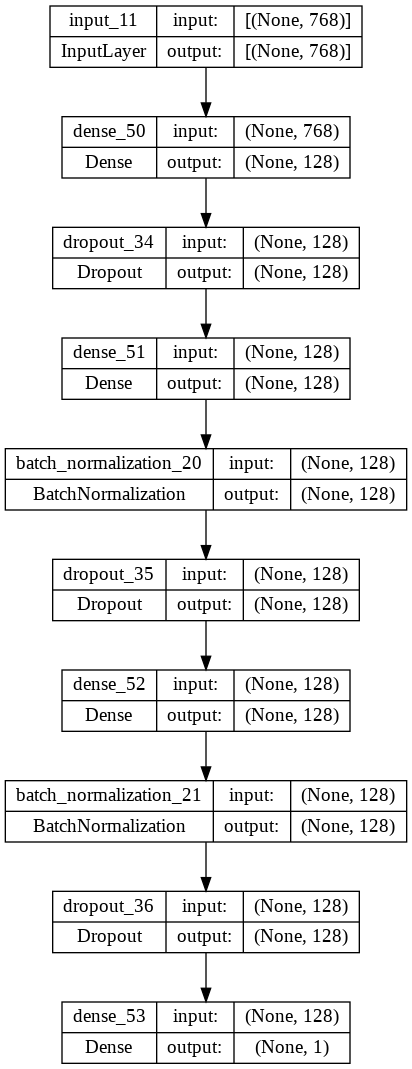

In [180]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/NLP transfer learning/model.png', show_shapes=True, show_layer_names=True)

In [181]:
model.fit( X_train_pooled_output, y_train.values,epochs=50, verbose=1, batch_size=128, validation_data=( X_test_pooled_output , y_test.values), callbacks = callbacks_list)

Epoch 1/50
619/625 [============================>.] - ETA: 0s - loss: 0.5013 - auroc: 0.5024
Epoch 1: val_auroc improved from -inf to 0.58481, saving model to /content/drive/MyDrive/NLP transfer learning
625/625 [==============================] - 7s 10ms/step - loss: 0.5005 - auroc: 0.5027 - val_loss: 0.4000 - val_auroc: 0.5848
Epoch 2/50
618/625 [============================>.] - ETA: 0s - loss: 0.3985 - auroc: 0.5425
Epoch 2: val_auroc improved from 0.58481 to 0.80404, saving model to /content/drive/MyDrive/NLP transfer learning
625/625 [==============================] - 6s 10ms/step - loss: 0.3977 - auroc: 0.5438 - val_loss: 0.5350 - val_auroc: 0.8040
Epoch 3/50
619/625 [============================>.] - ETA: 0s - loss: 0.2969 - auroc: 0.8327
Epoch 3: val_auroc improved from 0.80404 to 0.93176, saving model to /content/drive/MyDrive/NLP transfer learning
625/625 [==============================] - 7s 11ms/step - loss: 0.2967 - auroc: 0.8330 - val_loss: 0.8022 - val_auroc: 0.9318
Epoc

In [175]:
#model.reset_states()

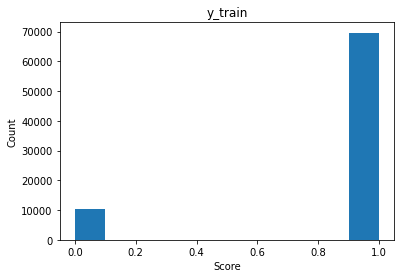

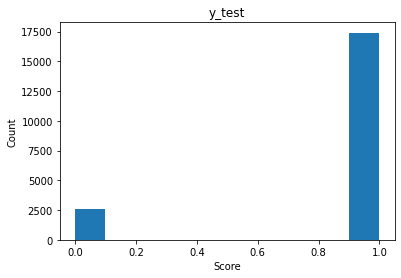

In [145]:
import matplotlib.pyplot as plt

# Create a bar plot of y_train
plt.hist(y_train)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('y_train')
plt.show()

# Create a bar plot of y_test
plt.hist(y_test)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('y_test')
plt.show()

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [133]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv


In [182]:
#read the csv file
test_df= pd.read_csv('test.csv')

<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [183]:
test_df

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...
...,...
347,Without a doubt this is by far the BEST beef g...
348,My 8 month old loves these. He hardly swallows...
349,the flavor palet for this coffee is deep and r...
350,This is the best granola my family has ever ha...


In [184]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
from tqdm import tqdm

def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')       #removing html tag
    return soup.get_text()



def get_class_count(test_df, model, max_seq_length=55):
  X_tests_tokens=[]
  X_tests_segment=[]
  X_tests_mask=[]

  # Preprocessing step(removing html tag)
  test_df['Text'] = test_df['Text'].apply(remove_html)
  
  # Tokenization
  for text in tqdm(test_df['Text']):
    tokens = tokenizer.tokenize(text)                        #tokenizing the text
    if len(tokens)>max_seq_length-2:
      tokens=tokens[0:(max_seq_length-2)]
    tokens=['[CLS]',*tokens,'[SEP]']                         #adding start and end token to the text
    tokens = tokenizer.convert_tokens_to_ids(tokens)         #converting tokens to ids
    X_tests_tokens.append(tokens)
    X_tests_mask.append(np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens))))           #creating mask for each text sentence
    X_tests_segment.append(np.array([0]*(max_seq_length)))                                    #creating segment for each text sentence
  
  X_tests_mask=np.asarray(X_tests_mask)
  X_tests_segment=np.asarray(X_tests_segment) 
    

  # Adding padding and creating mask and segment arrays
  X_tests_tokens = pad_sequences(X_tests_tokens, maxlen=max_seq_length, truncating='post', padding='post')         #padding ids

  # Getting embeddings from BERT model
  X_tests_pooled_output = bert_model.predict([X_tests_tokens, X_tests_mask, X_tests_segment])                      #getting vector form the pretrained BERT model for the test data
 
  # Printing shape of output
  print(X_tests_pooled_output.shape)

  # Predicting output using trained model
  y_pred = model.predict(X_tests_pooled_output)                                                                    #predicting the polarity of the test with the NN model which is trained by us
  y_pred = np.where(y_pred >= 0.5, 1, 0)


  class_1_count = sum(y_pred)                                                                                      #counting the number of positive and negative reviews
  class_0_count = len(y_pred)- class_1_count
  
  return {'class_0_count': class_0_count, 'class_1_count': class_1_count}


In [187]:
result=get_class_count(test_df, model, max_seq_length=55)

100%|██████████| 352/352 [00:00<00:00, 1395.52it/s]


11/11 [==============================] - 1s 120ms/step
(352, 768)
11/11 [==============================] - 0s 3ms/step


In [188]:
result

{'class_0_count': array([330]), 'class_1_count': array([22])}

<font color="Blue">Validation AUC of 95.07% is achieved in NN Model and for the given test.csv file we classified that 22 reviews belongs to class_1 and 330 review belongs to class_0 </font>

# Summary

**1)Preprocessing**
- Data cleaning and preprocessing steps such as removing html tags,checking for null values were performed on the dataset.
- The dataset was split into training and testing sets.

**2)Creating a BERT model from the Tensorflow HUB**
- A BERT model was imported from the Tensorflow HUB and specified as the base model for the classification task.
- The model was configured with the appropriate input shape and output size.

**3)Tokenization**
- The BERT model was used to tokenize the text data in the dataset.
- Special tokens such as '[CLS]' and '[SEP]' were added to the tokenized data to indicate the start and end of a sequence.

**4)Getting the pretrained embedding vector for a given review from the BERT**
- The BERT model was used to generate the pretrained embedding vectors for each review in the dataset.
The embedding vectors were generated by passing the tokenized review through the BERT model.

**5)Using the embedding data to apply a NN and classify the reviews**
- A neural network was trained on the embedding vectors and the corresponding labels in the dataset.
- The neural network was used to classify the reviews as positive or negative.

**6)Creating a data pipeline for the BERT model**
- A data pipeline was created to preprocess, tokenize, and generate embedding vectors for the reviews in the dataset.
- The data pipeline was used to feed the data into the neural network for classification